In [1]:
import timm
from PIL import Image
import torch
from torchvision import transforms
from torch.nn import functional as F
import timm.models.mlp_mixer
import numpy as np
import exchange_tensor_array as exchange
import matplotlib.pyplot as plt

from pathlib import Path
from torchvision.datasets.utils import download_url
import json

import copy

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#モデル作成
model = timm.create_model("gmlp_s16_224", pretrained=True)
model.eval()
print("model")

model


In [3]:
transform = transforms.Compose(
    [
        transforms.Resize(256),  # (256, 256) で切り抜く。
        transforms.CenterCrop(224),  # 画像の中心に合わせて、(224, 224) で切り抜く
        transforms.ToTensor(),  # テンソルにする。
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # 標準化する。
    ]
)

transform_beta = transforms.Compose(
    [
        transforms.Resize(256),  # (256, 256) で切り抜く。
        transforms.CenterCrop(224),  # 画像の中心に合わせて、(224, 224) で切り抜く
    ]
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'torch.Tensor'>


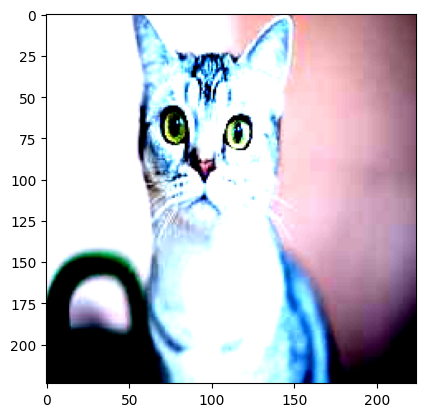

In [4]:
img = Image.open("cat.jpg")
#img = Image.open("cat_ablation.jpg")
print(type(img))
inputs = transform(img)
inputs = inputs.unsqueeze(0)
print(type(inputs))
plt.imshow(inputs[0].permute(1,2,0))
copy_inputs = copy.deepcopy(inputs)

In [5]:
import BatchAblationCAMforgMLP
exp = BatchAblationCAMforgMLP.BatchlAblationCAMfrogMLP(model)

In [6]:
exp.base_model_output(inputs)

('エジプトの猫', tensor(0.8991, grad_fn=<SelectBackward0>))

In [18]:
exp_out = exp.calc_value_input_image(inputs, batch_size=)

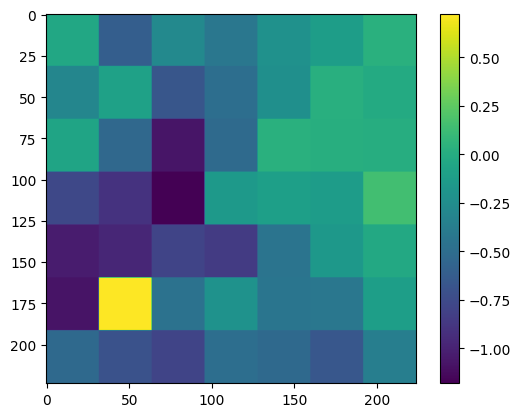

In [19]:
exchange.show_heatmap_with_colorbar(exp_out)

In [20]:
exp_outs = [exp.calc_value_input_image(inputs, i) for i in [112, 56, 32, 28, 16, 14, 8]]

KeyboardInterrupt: 

In [ ]:
exp_out_sum = np.zeros_like(exp_outs[0])
for out in exp_outs:
    exp_out_sum = exp_out_sum + out

In [ ]:
exchange.show_heatmap_with_colorbar(exp_out_sum)

In [ ]:
for i in exp_outs:
    exchange.show_heatmap_with_colorbar(i)

In [ ]:
exp = BatchAblationCAMforgMLP.BatchlAblationCAMfrogMLP(model)
exp_out = exp.calc_value_input_image(copy.deepcopy(inputs), 56)
exchange.show_heatmap_with_colorbar(exp_out)

In [ ]:
output = model(inputs)

In [ ]:
block_inputs = []
block_outputs = []
block_outputs_exchanged = []
#ブロックの入出力の抽出
for i in model.blocks:
    #_input = i.block_input
    _output = i.block_output
    #block_inputs.append(_input)
    block_outputs.append(_output)
    block_outputs_exchanged.append(exchange.exchange_tensor_to_array(_output))

In [ ]:
def get_classes():
    if not Path("data/imagenet_class_index.json").exists():
        # ファイルが存在しない場合はダウンロードする。
        download_url("https://git.io/JebAs", "data", "imagenet_class_index.json")

    # クラス一覧を読み込む。
    with open("data/imagenet_class_index.json") as f:
        data = json.load(f)
        return [x["ja"] for x in data]

class_names = get_classes()
def base_model_output(_input : torch.Tensor) -> tuple:
    """画像をモデルに入力した際の一番スコアが高いラベルを返す"""
    base_output = model(_input)
    batch_probs = F.softmax(base_output, dim=1)
    batch_probs, batch_indices = batch_probs.sort(dim=1, descending=True)

    return class_names[batch_indices[0][0]]

target_class_name = base_model_output(inputs)
class_index = class_names.index(base_model_output(inputs))


def pooling_only_output(_input : torch.Tensor) -> tuple:
    """中間層出力をプーリング層に入力した際のある特定のラベルに対するスコアを返す"""
    base_output = model.pooling_only(_input)
    batch_probs = F.softmax(base_output, dim=1)
    batch_probs = batch_probs[0][class_index].item()

    return batch_probs

def pooling_only_output_filtering(_input : torch.Tensor) -> float:
    """中間層出力をプーリング層に入力した際に最もスコアが高いラベルが特定のラベルの際はスコアを、そうでない場合は0を返す"""
    base_output = model.pooling_only(_input)
    batch_probs = F.softmax(base_output, dim=1)
    batch_probs, batch_indices = batch_probs.sort(dim=1, descending=True)
    if class_names[batch_indices[0][0]] == target_class_name:
        return batch_probs[0][0].item()
    else:
        return 0

In [ ]:
def rescaling_to_first_array(x: list[np.ndarray]) -> list[np.ndarray]:
    up = x[0].max()
    bottom = x[0].min()
    _range = up - bottom
    for i in x[1:]:
        tmp_up = i.max()
        tmp_bottom = i.min()
        tmp_range = tmp_up - tmp_bottom
        tmp_rate = _range / tmp_range
        i -= tmp_bottom
        i *= tmp_rate
        i += tmp_bottom * tmp_rate
    return x

In [ ]:
tmp = exchange.exchange_tensor_to_array(block_outputs[0])

In [ ]:
rescaled_tmp = rescaling_to_first_array(block_outputs_exchanged)

In [ ]:
exp_out = np.zeros((224, 224))
for i in rescaled_tmp:
    exp_out = exp_out * i
#exp_out /= len(rescaled_tmp)
exchange.show_heatmap_with_colorbar(exp_out)

In [ ]:
for i in block_outputs:
    tmp = exchange.exchange_tensor_to_array(i)
    print(tmp.max(), tmp.min())

In [ ]:
block_outputs_sum = np.zeros((224, 224))

In [ ]:
for outputs in block_outputs:
    block_outputs_sum  = block_outputs_sum + exchange.exchange_tensor_to_array(outputs)

In [ ]:
print(type(block_outputs_sum), block_outputs_sum.shape)

In [ ]:
exchange.show_heatmap_with_colorbar(block_outputs_sum)

In [ ]:
data_1 = np.array([1,2,3,4,5,6,7,8])
print(data_1)
print(data_1.shape)

data_2 = data_1.reshape(2, 4)
print(data_2)
print(data_2.shape)

In [ ]:
tmp = exchange.exchange_tensor_to_array(block_outputs[0])
b = np.where(tmp < 5, 100, -100)
print(np.where(tmp < 2.5))
exchange.show_heatmap_with_colorbar(np.where(tmp < 3, 255, 0))

In [ ]:
base_img = transform_beta(img)
alpha_img = np.where(tmp < 3, 255, 0)
print(224 * 224)
print(type(alpha_img), alpha_img.size)
alpha_img = Image.fromarray(alpha_img.astype(np.uint8))
alpha_img.show()
base_img.show()